In [1]:
# GPU TEST

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))    

Found GPU at: /device:GPU:0


In [2]:
# Importing libraries
import keras
from keras.models import Sequential
from keras.layers import Dense

import pickle
import gzip
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [3]:
import os,random
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise,AlphaDropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

In [4]:
with open('2016.04C.multisnr.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    Xd = u.load()

In [5]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [6]:
X

array([[[  24.714563  ,  -29.568644  ,   92.68012   , ...,
           47.776936  ,  -18.414425  ,    2.6127734 ],
        [ -48.443947  ,    7.4777226 ,  -31.440838  , ...,
          -35.22897   ,  -18.624535  ,   55.108932  ]],

       [[  -7.4243298 ,  119.80825   , -111.365616  , ...,
          -31.315722  , -113.13201   ,   40.65939   ],
        [ 167.00078   ,  -21.273016  ,   38.65764   , ...,
         -115.24621   ,  -80.3968    ,   48.018898  ]],

       [[ 140.26158   ,  -55.305504  ,   91.71414   , ...,
            8.354092  ,  -52.09348   ,  -59.840755  ],
        [  12.849184  ,   23.583422  ,   -3.1462991 , ...,
           73.667694  ,   64.10245   ,   36.153652  ]],

       ...,

       [[  -0.7416414 ,   -0.7185424 ,   -0.689575  , ...,
           -0.7065344 ,   -0.7066991 ,   -0.6974531 ],
        [  -1.7302197 ,   -1.7222215 ,   -1.7496604 , ...,
           -1.729324  ,   -1.7172005 ,   -1.7255902 ]],

       [[  -0.6813814 ,   -0.69127196,   -0.6815096 , ...,
        

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.8
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
#changed from x to combined data
#X_train = combined_Data[train_idx]
#X_test =  combined_Data[test_idx]
X_train = X[train_idx]
X_test =  X[test_idx]

In [9]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1 
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [10]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(129648, 2, 128) [2, 128]


In [11]:
# Set up some params
nb_epoch = 100 # number of epochs to train on
batch_size = 500 # training batch size

In [12]:
import keras.models as models
# Build VT-CNN2 Neural Net model using Keras primitives --
# - Reshape [N,2,128] to [N,1,2,128] on input
# - Pass through 2 2DConv/ReLu layers
# - Pass through 2 Dense layers (ReLu and Softmax)
# - Perform categorical cross entropy optimization
drop_rate_1 = 0.6 # dropout rate (%)
#drop_rate_2 = 0.5 # dropout rate (%)
#drop_rate_3 = 0.2 # dropout rate (%)


cnn = keras.models.Sequential()
cnn.add(Reshape(in_shp+[1], input_shape=in_shp))

cnn.add(ZeroPadding2D((0, 2)))
cnn.add(Conv2D(256, (1, 2),padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform',data_format="channels_last"))
cnn.add(Dropout(drop_rate_1))

cnn.add(AveragePooling2D((1,2),padding="valid"))

cnn.add(ZeroPadding2D((0,2)))
cnn.add(Conv2D(96,(1, 8), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform',data_format="channels_last"))
cnn.add(Dropout(drop_rate_1))


cnn.add(Conv2D(64,(2,6), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform',data_format="channels_last"))
cnn.add(Dropout(drop_rate_1))

#cnn.add(AveragePooling2D((1,2),padding="valid"))

cnn.add(Flatten())

cnn.add(GaussianNoise(0.01))
cnn.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal'))

cnn.add(Dense(256, activation = 'relu', kernel_initializer = 'he_normal'))

cnn.add(Dense(64, activation = 'relu', kernel_initializer = 'he_normal'))

cnn.add(Dense(len(classes), kernel_initializer = 'he_normal'))
cnn.add(Activation('softmax'))
cnn.add(Reshape([len(classes)]))
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 131, 256)       768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 131, 256)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 65, 256)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 69, 256)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 2, 62, 96)        

In [19]:
# - call the main training loop in keras for our network+dataset
filepath = 'convmod_SEP_CNN18_0.5.wts.h5'
# we re-load the best weights once training is finished
cnn.load_weights(filepath)

In [20]:
scscore = cnn.evaluate(X_test, Y_test, batch_size=batch_size)
print(cnn.metrics_names)
print (scscore)

32412/32412 [==============================] - 4s 112us/step
['loss', 'accuracy']
[0.8242874012781726, 0.6894668936729431]


In [21]:
scscore = cnn.evaluate(X_test, Y_test, batch_size=batch_size)
print(cnn.metrics_names)
print (scscore)

32412/32412 [==============================] - 4s 118us/step
['loss', 'accuracy']
[0.8242874012781726, 0.6894668936729431]


In [34]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.PuRd , labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

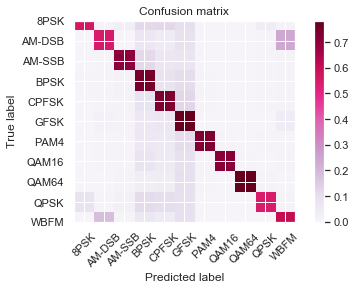

In [35]:
# Plot confusion matrix
test_Y_hat = cnn.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
# on the right its a color chart to indicate that the darker the color the easier and thee most to identify

Overall Accuracy:  0.2059738643434972
Overall Accuracy:  0.14384858044164037
Overall Accuracy:  0.16230677764565993
Overall Accuracy:  0.2236760124610592
Overall Accuracy:  0.2747584541062802
Overall Accuracy:  0.3628879037365421
Overall Accuracy:  0.5717689100655152
Overall Accuracy:  0.7453646477132262
Overall Accuracy:  0.8224661071659135
Overall Accuracy:  0.9489858635525507
Overall Accuracy:  0.9226081657525899
Overall Accuracy:  0.9166666666666666
Overall Accuracy:  0.93595166163142
Overall Accuracy:  0.9505322479649343
Overall Accuracy:  0.9011663597298957
Overall Accuracy:  0.9292251372788286
Overall Accuracy:  0.9651802076970067
Overall Accuracy:  0.8978940650925336
Overall Accuracy:  0.947206875383671
Overall Accuracy:  0.9657492354740062


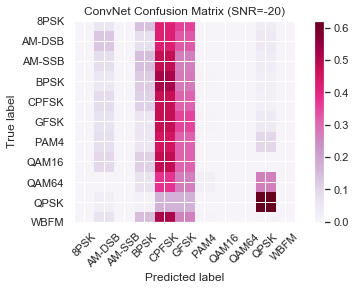

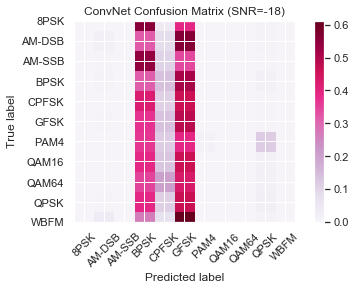

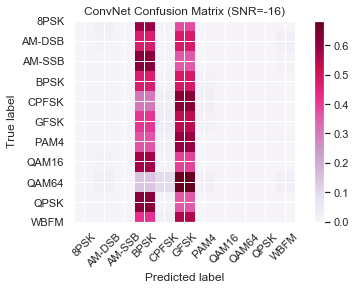

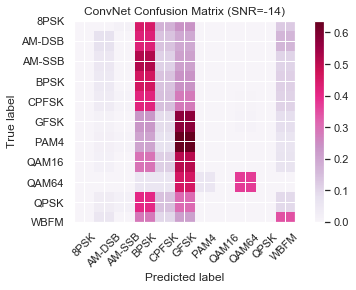

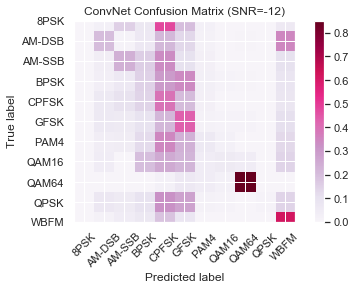

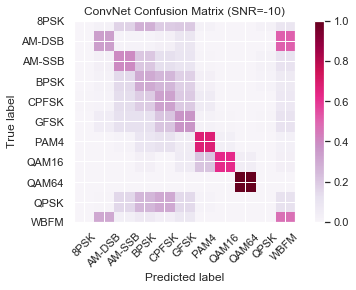

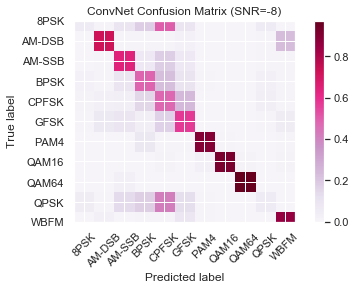

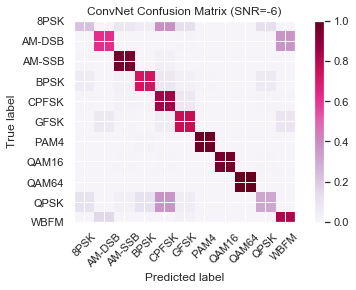

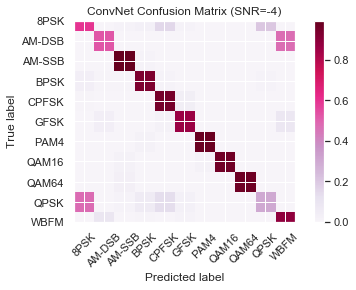

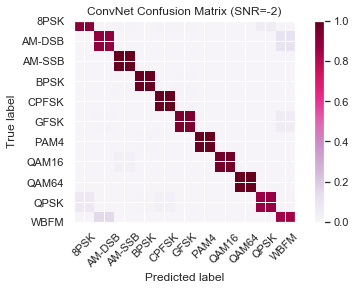

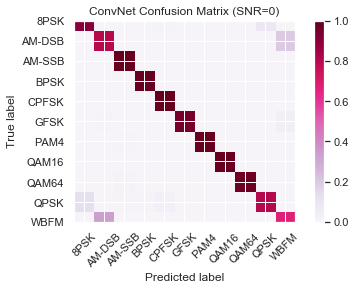

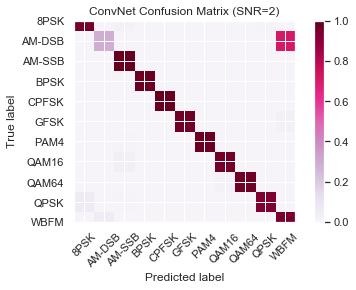

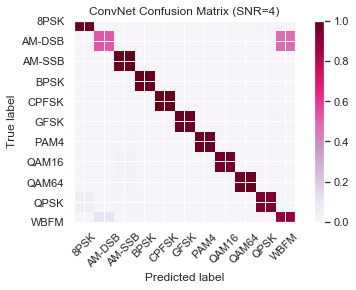

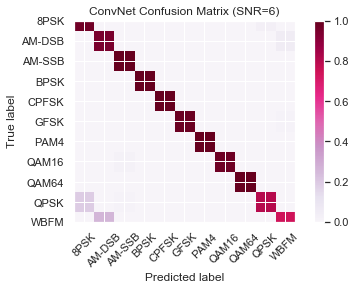

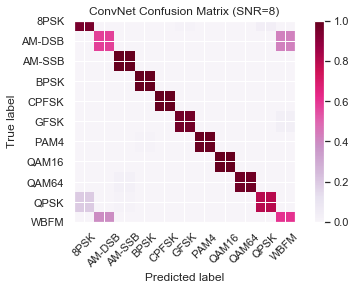

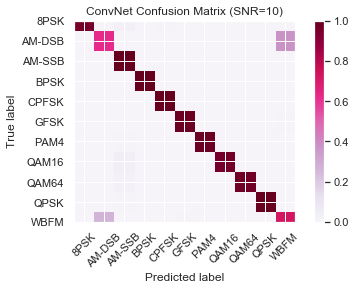

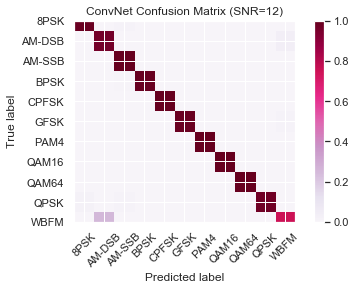

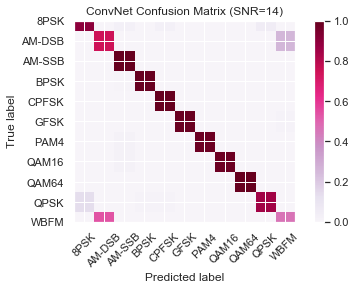

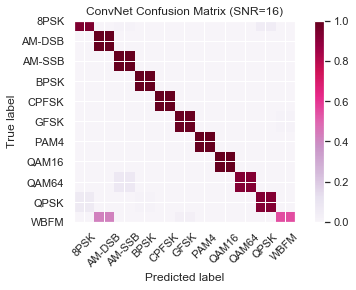

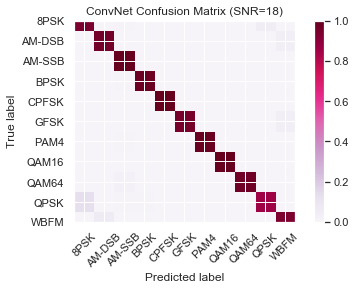

In [36]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = cnn.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy on RadioML")